<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
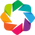

In [3]:
import os
import pandas as pd, numpy as np
import holoviews as hv
from facteus import facteus
hv.extension('bokeh')

import matplotlib.pyplot as plt
from matplotlib import ticker

# TODO adjust for income

# Import MARTS historical data

In [4]:
# MARTS data
marts = pd.read_csv('marts.csv')
marts = marts.set_index(pd.to_datetime(marts['date'])).drop('date', axis=1)

In [5]:
# Seasonal adjustment
sa = pd.read_csv('seas_adj.csv').set_index('Sector')
march_sa = sa['2020-03-31']

# Import daily metrics from Signal

In [6]:
signal_connection = {
    'user': os.getenv('SNOWSQL_USER'),
    'password': os.getenv('SNOWSQL_PWD'),
    'account': 'arminsight',
    'warehouse': 'JCHIN_WH',
    'database': 'SIGNAL_MONETIZATION',
    'schema': 'PUBLIC'
}

In [9]:
spend_query = """
select
  month(transaction_dttm) as txn_mon,
  year(transaction_dttm) as txn_yr,
  merchant_category_xcd as mcc_cde,
  sum(least(transaction_amt, 1e5) - coalesce(transaction_cashback_amt, 0)) as net_amt
  -- count(distinct account_reference_xid) as card_cnt,
  -- count(distinct fi_transaction_id) as txn_cnt

from
  signal_monetization.public.signal_master_hist_tagged_latest as signal
  -- clean database but only starts on 2018-12-31

where
      decision_xcd = 'T' -- only approved transactions
  and transaction_dttm > to_date('2018-12-31') -- only starts on 2018-12-31
  and transaction_iso_currency_xcd = '840' -- USD; there are CAD ('124') transactions too
  and mcc_cde not between '5511' and '5533' -- exclude auto dealers
  and mcc_cde not between '5551' and '5599' -- exclude motorcycle, boat, farm equipment dealers
  
group by
  1,2,3
  
union

select
  month(transaction_dttm) as txn_mon,
  year(transaction_dttm) as txn_yr,
  merchant_category_xcd as mcc_cde,
  sum(least(transaction_amt, 1e5) - coalesce(transaction_cashback_amt, 0)) as net_amt
  -- count(distinct account_reference_xid) as card_cnt,
  -- count(distinct fi_transaction_id) as txn_cnt

from
  signal_monetization.public.signal_master_hist_tagged as signal

where
      decision_xcd = 'T' -- only approved transactions
  and transaction_dttm > to_date('2017-12-31') -- we just need one extra year to calculate yoy growth
  and transaction_dttm < to_date('2019-01-01')
  and transaction_iso_currency_xcd = '840' -- USD; there are CAD ('124') transactions too
  and mcc_cde not between '5511' and '5533' -- exclude auto dealers
  and mcc_cde not between '5551' and '5599' -- exclude motorcycle, boat, farm equipment dealers
  
group by
  1,2,3

"""

In [10]:
spend_raw = facteus.execute_snowflake_query(spend_query, signal_connection)

In [12]:
spend = facteus.pretty_format(spend_raw)

In [19]:
spend['tran_month'] = spend['txn_yr'].astype(str) + '-' + spend['txn_mon'].astype(str).str.zfill(2)

In [22]:
spend = spend[['tran_month', 'mcc_cde', 'net_amt']]

In [29]:
spend['tran_month'].unique()

array(['2019-12', '2019-02', '2018-03', '2018-06', '2018-09', '2018-04',
       '2018-07', '2019-11', '2018-02', '2019-05', '2019-08', '2019-04',
       '2017-12', '2018-11', '2019-03', '2018-05', '2018-12', '2019-07',
       '2020-06', '2018-01', '2018-10', '2018-08', '2020-05', '2020-02',
       '2019-09', '2020-01', '2019-10', '2020-04', '2019-01', '2019-06',
       '2020-03'], dtype=object)

In [30]:
hv.Curve(spend.groupby('tran_month')['net_amt'].sum().loc['2018-01':'2020-05']).opts(width=900, xrotation=45)

:Curve   [tran_month]   (net_amt)

In [26]:
spend.to_csv('spend.csv')

# Set up analysis functions

In [51]:
def rolling_mean(df, start_date, end_date, feature, n=7):
    data_start_date = pd.to_datetime(start_date) + n*pd.Timedelta('-1d')
    rm = df[feature].loc[data_start_date:end_date].groupby('txn_date').sum().rolling(n).mean().loc[start_date:end_date]
    return rm

In [52]:
def extract_ytd_rolling_mean_comps(df, feature):
    data_2019 = rolling_mean(df, '2019-01-01', '2019-05-02', feature, n=7)
    data_2020 = rolling_mean(df, '2020-01-01', '2020-05-01', feature, n=7)
    data_2019.index = data_2020.index
    return data_2019, data_2020

In [53]:
def plot_yoy_comp(data_2019, data_2020, title):
    fig, axes = plt.subplots(2, 1, figsize=(16,10))
    ax1, ax2 = axes
    fig.suptitle(title)

    ax1.plot(data_2019, label='2019')
    ax1.plot(data_2020, label='2020')
    ax1.legend()
    ax1.set_title('Absolute levels')

    ax2.plot(data_2020/data_2019)
    ax2.set_title('2020 / 2019 levels')

In [54]:
def resample_monthly(df, feature):
    return df.resample('1M')[feature].sum().iloc[:-1] # Cut off current month

In [55]:
def yoy_monthly_chg(df, feature):
    return resample_monthly(df, feature).pct_change(12).dropna()

In [56]:
def align_marts_with_feature_yoy_chg(marts, category, df, feature):
    return pd.DataFrame([marts[category].pct_change(12), yoy_monthly_chg(df, feature)]).T.dropna(subset=[feature])

In [57]:
def predict_month(marts, category, yoy, feature, date):
    year_ago = (pd.to_datetime(date) + pd.offsets.MonthEnd(-12)).strftime('%Y-%m-%d')
    return (1 + yoy.loc[date, feature]) * marts.loc[year_ago, category]

In [58]:
def plot_prediction(marts, category, yoy, feature, date):
    next_month = predict_month(marts, category, yoy, feature, date)
    prediction = marts[category].copy()
    prediction.loc[date] = next_month
    prediction.plot(figsize=(16,6))

In [59]:
def diffs(df, feature, marts_code, start_month):
    return (df[feature] - df[marts_code]).loc[start_month:]

In [60]:
def error(diff, q):
    return np.abs(diff).quantile(q)

In [61]:
def plot_publication(data_2019, data_2020, title, filename):
    fig, ax = plt.subplots(figsize=(10,6))
    fig.suptitle(title)

    ax.plot(data_2020/data_2019 - 1)
    ax.set_title('Year on year growth')
    ax.set_ylabel('Seven day moving average annual growth')
    ax.set_xlabel('Date')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
    ax.yaxis.set_tick_params(labelright='true')
    ax.axhline(color='k', linewidth=0.3)
    
    # plt.savefig(filename)

In [62]:
def weekly_annual_change(df, feature, start_date, end_date):
    return df.groupby('txn_date')[feature].sum().resample('W').sum().pct_change(52).loc[start_date:end_date]

## All sectors

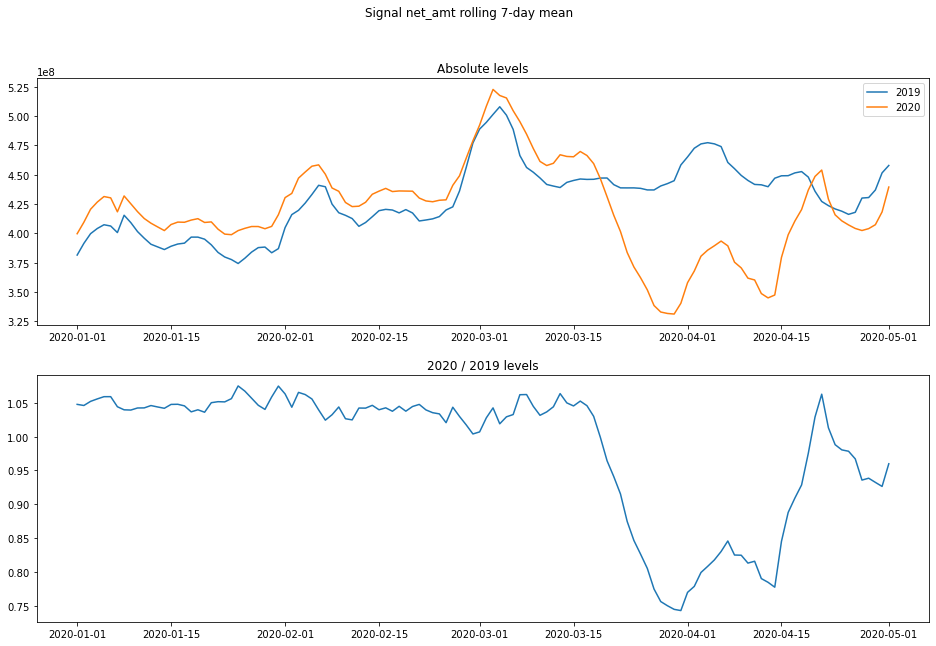

In [63]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(daily_metrics, 'net_amt'), 'Signal net_amt rolling 7-day mean')

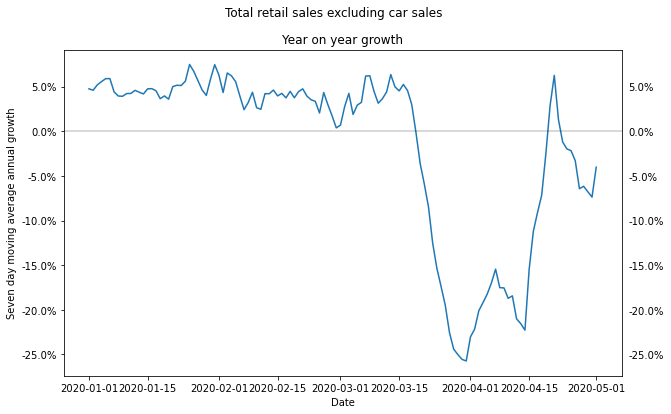

In [64]:
plot_publication(*extract_ytd_rolling_mean_comps(daily_metrics, 'net_amt'), 'Total retail sales excluding car sales', 'ex_mvpd.png')

In [65]:
ex_mvpd_raw = align_marts_with_feature_yoy_chg(marts, 'ex_mvpd_raw', daily_metrics, 'net_amt')

In [68]:
ex_mvpd_diff = diffs(ex_mvpd_raw, 'net_amt', 'ex_mvpd_raw', '2019-07')
ex_mvpd_diff

2019-07-31   -0.004790
2019-08-31   -0.014411
2019-09-30   -0.015229
2019-10-31   -0.032098
2019-11-30    0.001726
2019-12-31   -0.041560
2020-01-31    0.015644
2020-02-29    0.000909
2020-03-31   -0.059218
2020-04-30         NaN
Freq: M, dtype: float64

In [142]:
ex_mvpd_diff.mean(), ex_mvpd_diff.median()

(-0.016558662808991098, -0.014410940233951841)

In [69]:
error(ex_mvpd_diff, 0.9)

0.04509181967495031

In [70]:
ex_mvpd_prediction = predict_month(marts, 'ex_mvpd_raw', ex_mvpd_raw, 'net_amt', '2020-04-30')
ex_mvpd_prediction

367744.2557592531

In [71]:
ex_mvpd_prediction / marts['ex_mvpd_raw'].loc['2019-04-30'] - 1

-0.09417688702527449

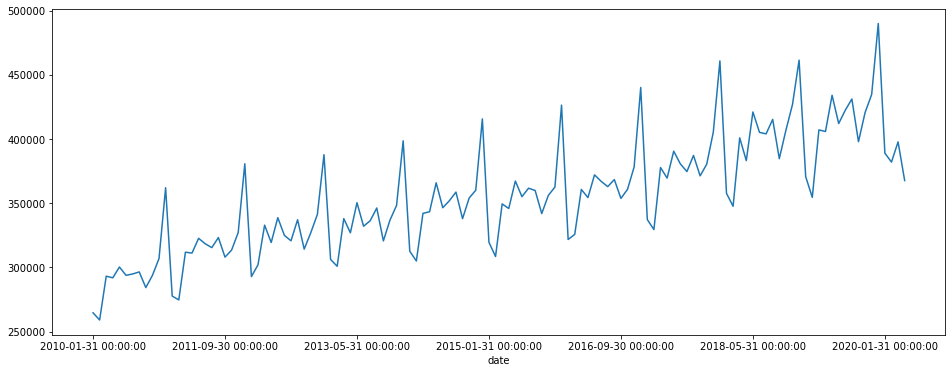

In [72]:
plot_prediction(marts, 'ex_mvpd_raw', ex_mvpd_raw, 'net_amt', '2020-04-30')

## Food service

In [75]:
food_service_daily = daily_metrics[daily_metrics['mcc_cde'].isin(['5811', '5812', '5813', '5814'])]

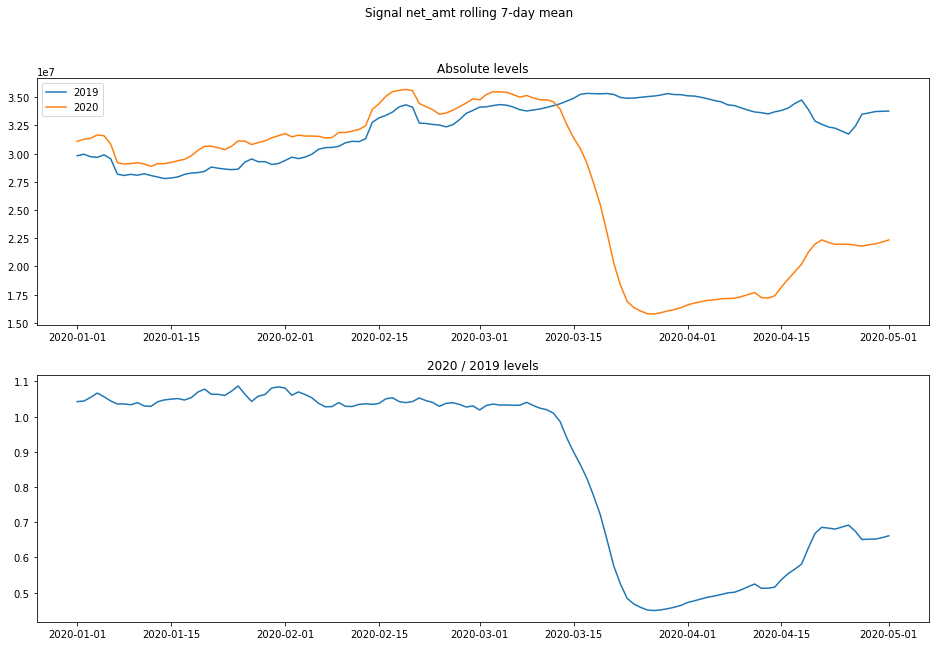

In [76]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(food_service_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

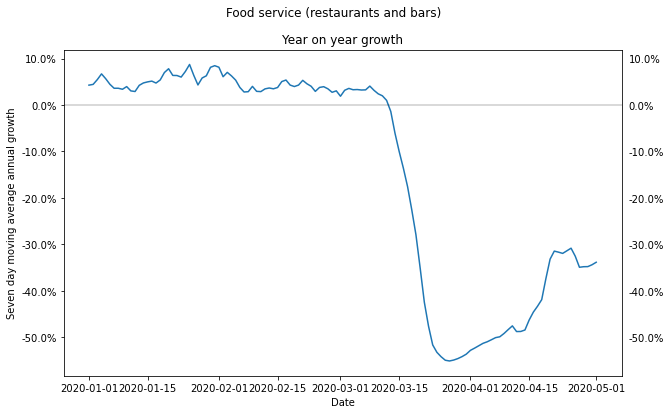

In [77]:
plot_publication(*extract_ytd_rolling_mean_comps(food_service_daily, 'net_amt'), 'Food service (restaurants and bars)', 'food_service.png')

In [78]:
food_drink_raw = align_marts_with_feature_yoy_chg(marts, 'food_drink_raw', food_service_daily, 'net_amt')

In [79]:
food_drink_diff = diffs(food_drink_raw, 'net_amt', 'food_drink_raw', '2019-07')
food_drink_diff

2019-07-31    0.019621
2019-08-31    0.018043
2019-09-30   -0.007805
2019-10-31   -0.033662
2019-11-30   -0.007922
2019-12-31   -0.038319
2020-01-31   -0.000312
2020-02-29   -0.010115
2020-03-31   -0.052324
2020-04-30         NaN
Freq: M, dtype: float64

In [143]:
food_drink_diff.mean(), food_drink_diff.median()

(-0.012532775783500082, -0.007922350311819315)

In [144]:
error(food_drink_diff, 0.9)

0.0411199208824766

In [145]:
food_service_predict = predict_month(marts, 'food_drink_raw', food_drink_raw, 'net_amt', '2020-04-30')
food_service_predict

37958.7924133709

In [146]:
food_service_predict / marts['food_drink_raw'].loc['2019-04-30'] - 1

-0.4040350994085551

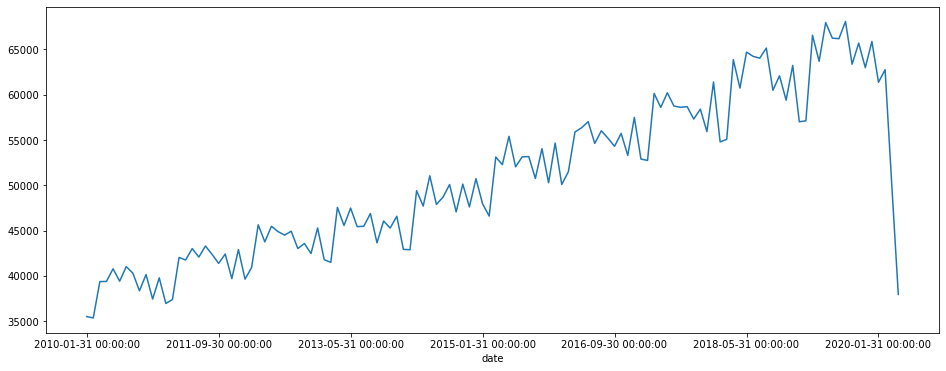

In [83]:
plot_prediction(marts, 'food_drink_raw', food_drink_raw, 'net_amt', '2020-04-30')

## Food and beverage stores

In [84]:
food_bev_daily = daily_metrics[(daily_metrics['mcc_cde'] >= '5411') & (daily_metrics['mcc_cde'] <= '5499')]

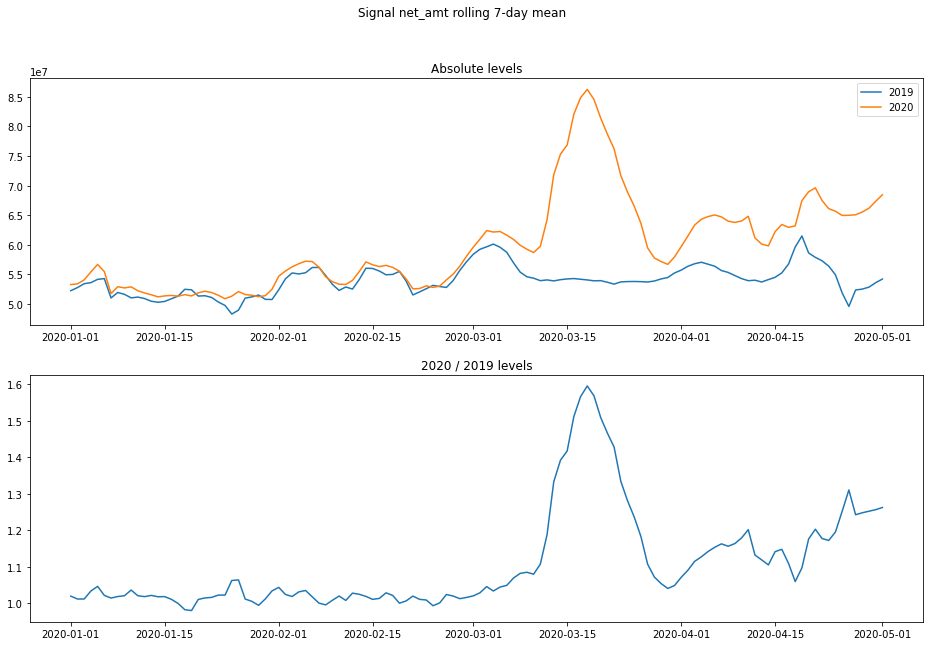

In [85]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(food_bev_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

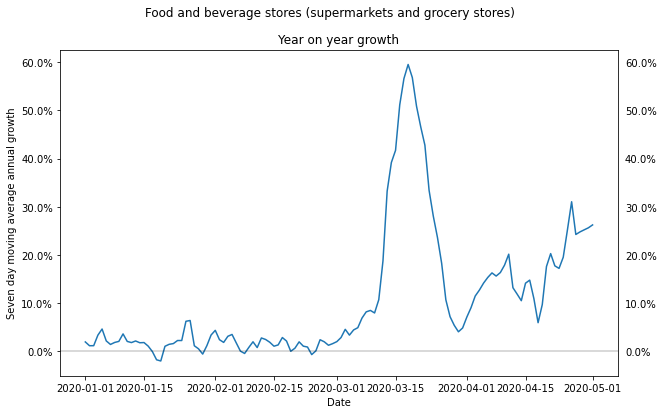

In [86]:
plot_publication(*extract_ytd_rolling_mean_comps(food_bev_daily, 'net_amt'), 'Food and beverage stores (supermarkets and grocery stores)', 'food_bev.png')

In [87]:
food_bev_raw = align_marts_with_feature_yoy_chg(marts, 'food_bev_raw', food_bev_daily, 'net_amt')

In [88]:
food_bev_diff = diffs(food_bev_raw, 'net_amt', 'food_bev_raw', '2019-07')
food_bev_diff

2019-07-31   -0.031557
2019-08-31   -0.036224
2019-09-30   -0.028948
2019-10-31   -0.038505
2019-11-30   -0.013074
2019-12-31   -0.049218
2020-01-31    0.011539
2020-02-29   -0.018294
2020-03-31   -0.063435
2020-04-30         NaN
Freq: M, dtype: float64

In [147]:
food_bev_diff.mean(), food_bev_diff.median()

(-0.02974629587604443, -0.03155663536740594)

In [89]:
error(food_bev_diff, 0.9)

0.052061642092921544

In [90]:
food_bev_predict = predict_month(marts, 'food_bev_raw', food_bev_raw, 'net_amt', '2020-04-30')
food_bev_predict

74667.60399892849

In [91]:
food_bev_predict / marts['food_bev_raw'].loc['2019-04-30'] - 1

0.19016854486074397

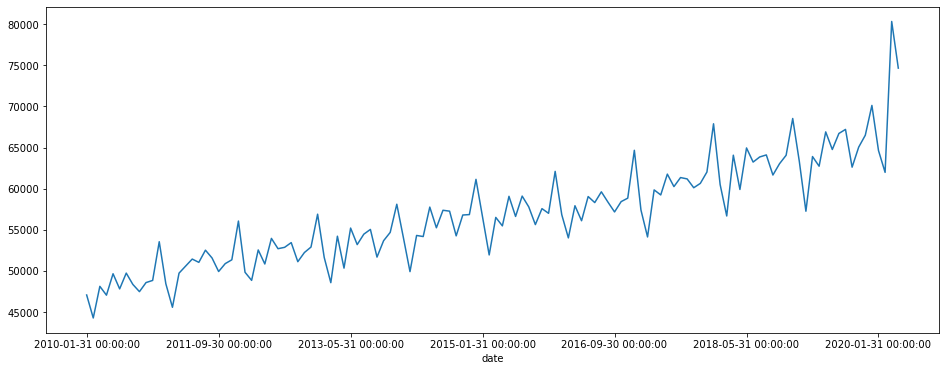

In [92]:
plot_prediction(marts, 'food_bev_raw', food_bev_raw, 'net_amt', '2020-04-30')

## General merchandise

In [93]:
gen_merch_daily = daily_metrics[(daily_metrics['mcc_cde'] >= '5300') & (daily_metrics['mcc_cde'] <= '5399')]

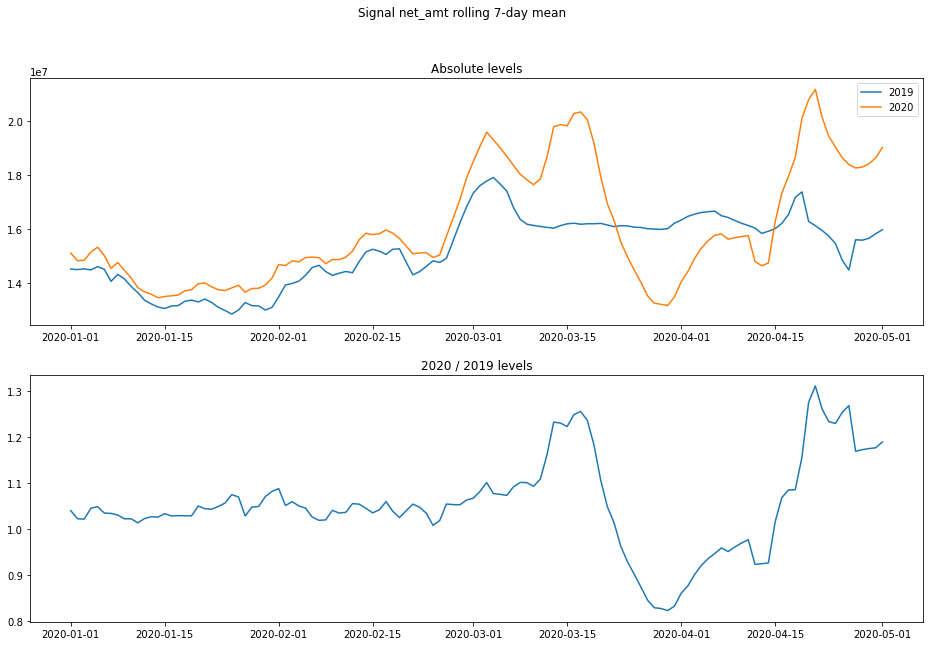

In [94]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(gen_merch_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

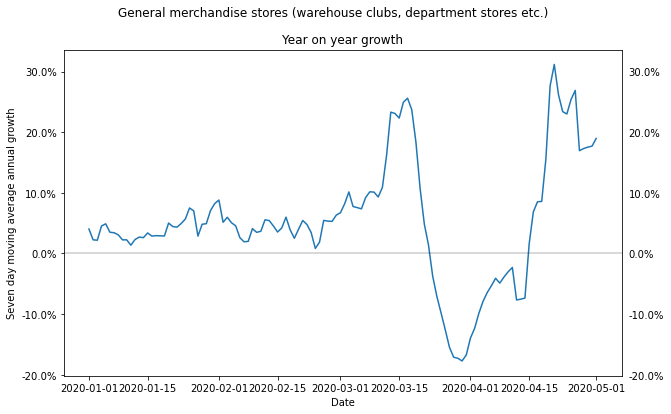

In [95]:
plot_publication(*extract_ytd_rolling_mean_comps(gen_merch_daily, 'net_amt'), 'General merchandise stores (warehouse clubs, department stores etc.)', 'gen_merch.png')

In [96]:
gen_merch_raw = align_marts_with_feature_yoy_chg(marts, 'gen_merch_raw', gen_merch_daily, 'net_amt')

In [97]:
gen_merch_diff = diffs(gen_merch_raw, 'net_amt', 'gen_merch_raw', '2019-07')
gen_merch_diff

2019-07-31   -0.030243
2019-08-31   -0.021712
2019-09-30    0.020568
2019-10-31    0.000536
2019-11-30   -0.005966
2019-12-31    0.010068
2020-01-31    0.026898
2020-02-29    0.034370
2020-03-31   -0.051430
2020-04-30         NaN
Freq: M, dtype: float64

In [148]:
gen_merch_diff.mean(), gen_merch_diff.median()

(-0.001879072591670799, 0.000535691160062246)

In [98]:
error(gen_merch_diff, 0.9)

0.03778185318202785

In [99]:
gen_merch_predict = predict_month(marts, 'gen_merch_raw', gen_merch_raw, 'net_amt', '2020-04-30')
gen_merch_predict

62672.40697686398

In [100]:
gen_merch_predict / marts['gen_merch_raw'].loc['2019-04-30'] - 1

0.10625045411300338

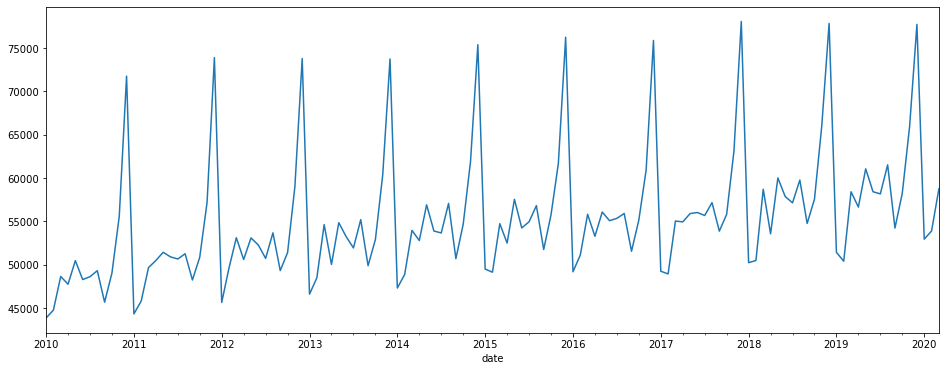

In [101]:
plot_prediction(marts, 'gen_merch_raw', gen_merch_raw, 'net_amt', '2020-03-31')

In [102]:
gen_merch_sa_factor = march_sa['General merchandise stores']
gen_merch_sa = gen_merch_sa_factor * gen_merch_predict
gen_merch_sa / marts['gen_merch_raw'].loc['2019-04-30'] - 1

0.06531918731082231

## Nonstore retail

In [105]:
nonstore_query = """
select
  date(transaction_dttm) as txn_date,
  merchant_category_xcd as mcc_cde,
  sum(least(transaction_amt, 1e5) - coalesce(transaction_cashback_amt, 0)) as net_amt

from
  signal_monetization.public.signal_master_hist_tagged_latest as signal

where
  decision_xcd = 'T' -- only approved transactions
  and txn_date > to_date('2018-12-31') -- no data prior to that
  and transaction_iso_currency_xcd = '840' -- USD; there are CAD ('124') transactions too
  and (merchant_name like '%WALMART.COM%' or merchant_name like '%TARGET.COM%' or
      arm_merchant_id in
      ('1005',
       '1132',
       '1135',
       '1139',
       '1148',
       '122',
       '1256',
       '1297',
       '1325',
       '1353',
       '1563',
       '1564',
       '1565',
       '1566',
       '1579',
       '1581',
       '182',
       '183',
       '189',
       '217',
       '268',
       '332',
       '345',
       '349',
       '358',
       '361',
       '368',
       '461',
       '484',
       '52',
       '523',
       '526',
       '532',
       '589',
       '713',
       '736',
       '749',
       '766',
       '776',
       '849',
       '870')
  )

group by
  date(transaction_dttm), mcc_cde
  
union

select
  to_date(transaction_dttm) as txn_date,
  merchant_category_xcd as mcc_cde,
  sum(least(transaction_amt, 1e5) - coalesce(transaction_cashback_amt, 0)) as net_amt

from
  signal_monetization.public.signal_master_hist_tagged as signal

where
  decision_xcd = 'T' -- only approved transactions
  and txn_date > to_date('2017-12-31') -- no need to go back further
  and txn_date < to_date('2019-01-01') -- avoid overlap with latest
  and transaction_iso_currency_xcd = '840' -- USD; there are CAD ('124') transactions too
  and (merchant_name like '%WALMART.COM%' or merchant_name like '%TARGET.COM%' or
      arm_merchant_id in
      ('1005',
       '1132',
       '1135',
       '1139',
       '1148',
       '122',
       '1256',
       '1297',
       '1325',
       '1353',
       '1563',
       '1564',
       '1565',
       '1566',
       '1579',
       '1581',
       '182',
       '183',
       '189',
       '217',
       '268',
       '332',
       '345',
       '349',
       '358',
       '361',
       '368',
       '461',
       '484',
       '52',
       '523',
       '526',
       '532',
       '589',
       '713',
       '736',
       '749',
       '766',
       '776',
       '849',
       '870')
  )

group by
  txn_date, mcc_cde;
"""

In [106]:
nonstore_daily = facteus.execute_snowflake_query(nonstore_query, signal_connection)

In [111]:
nonstore_daily = facteus.pretty_format(nonstore_daily, index='txn_date')

In [112]:
hv.Curve(nonstore_daily.groupby('txn_date').sum().loc['2020-03':]).opts(width=900)

:Curve   [txn_date]   (net_amt)

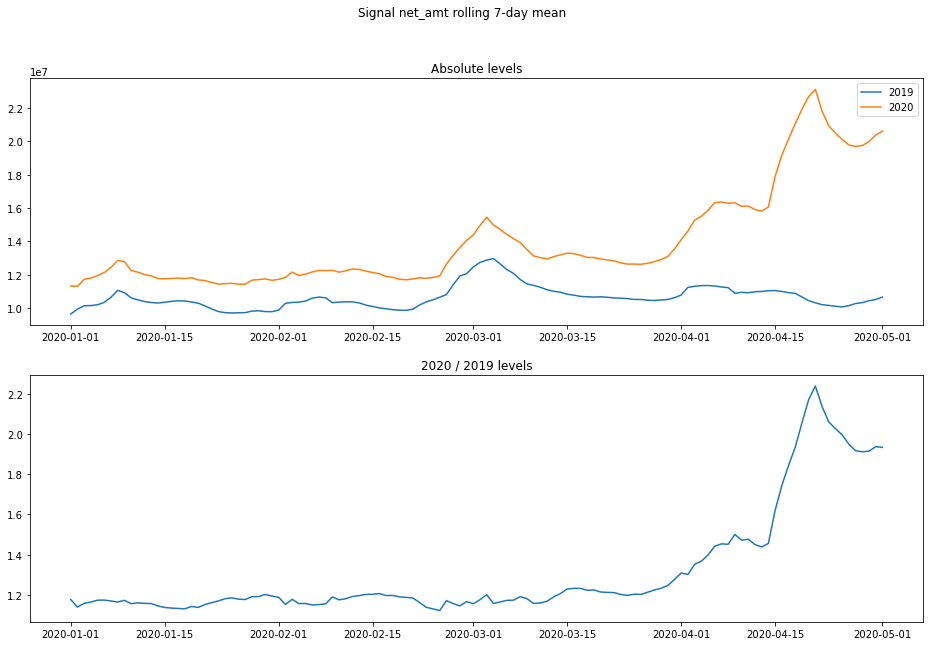

In [113]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(nonstore_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

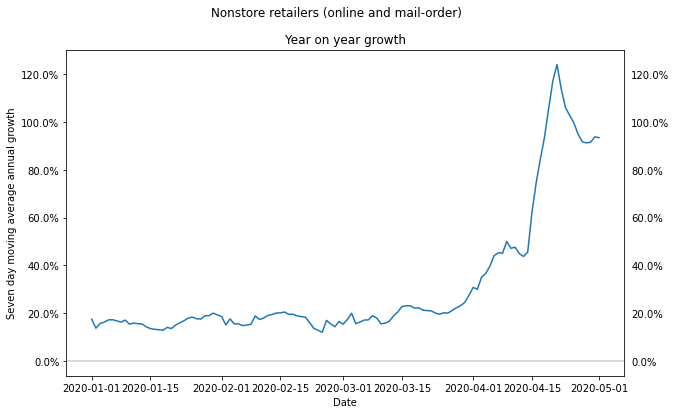

In [114]:
plot_publication(*extract_ytd_rolling_mean_comps(nonstore_daily, 'net_amt'), 'Nonstore retailers (online and mail-order)', 'nonstore.png')

In [115]:
nonstore_raw = align_marts_with_feature_yoy_chg(marts, 'nonstore_raw', nonstore_daily, 'net_amt')

In [116]:
nonstore_diff = diffs(nonstore_raw, 'net_amt', 'nonstore_raw', '2019-07')
nonstore_diff

2019-07-31    0.018146
2019-08-31    0.016182
2019-09-30    0.020619
2019-10-31    0.030617
2019-11-30    0.008090
2019-12-31   -0.037987
2020-01-31    0.098456
2020-02-29    0.126981
2020-03-31    0.090174
2020-04-30         NaN
Freq: M, dtype: float64

In [149]:
nonstore_diff.mean(), nonstore_diff.median()

(0.04125293972120588, 0.020618824457447005)

In [117]:
error(nonstore_diff, 0.9)

0.10416109422117069

In [118]:
nonstore_predict = predict_month(marts, 'nonstore_raw', nonstore_raw, 'net_amt', '2020-04-30')
nonstore_predict

105549.1655925741

In [119]:
nonstore_predict / marts['nonstore_raw'].loc['2019-04-30'] - 1

0.7594753303534665

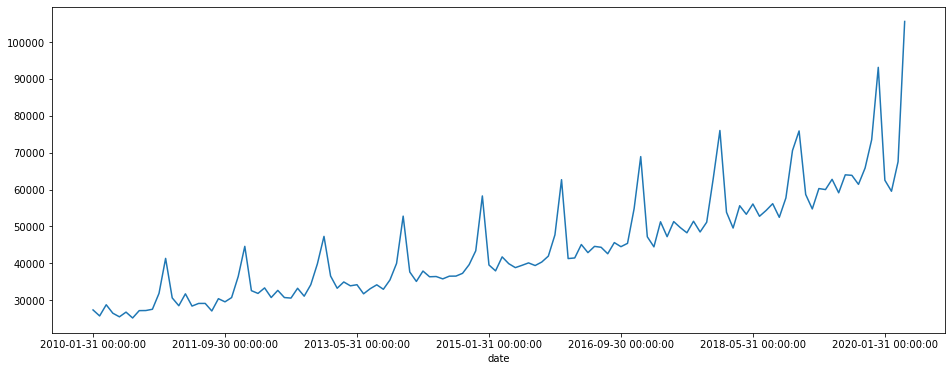

In [120]:
plot_prediction(marts, 'nonstore_raw', nonstore_raw, 'net_amt', '2020-04-30')

In [121]:
nonstore_sa_factor = march_sa['Nonstore retailers']
nonstore_sa = nonstore_sa_factor * nonstore_predict
nonstore_sa / marts['nonstore_raw'].loc['2019-03-31'] - 1

0.7164744329879962

## Building materials

In [122]:
build_daily = daily_metrics[((daily_metrics['mcc_cde'] >= '5198') & (daily_metrics['mcc_cde'] <= '5261')) | ((daily_metrics['mcc_cde'] >= '5712') & (daily_metrics['mcc_cde'] <= '5719'))]

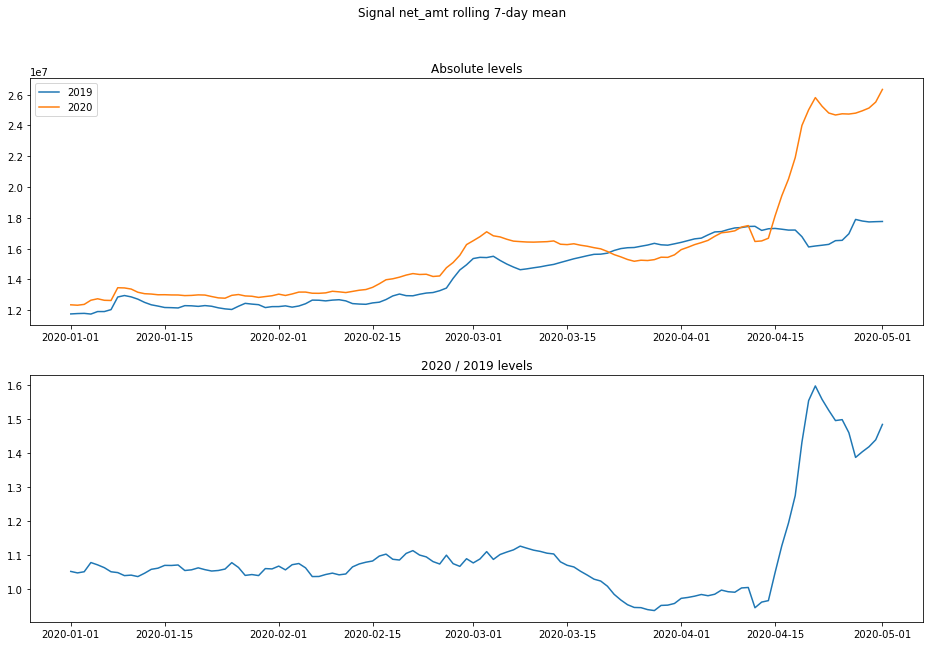

In [123]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(build_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

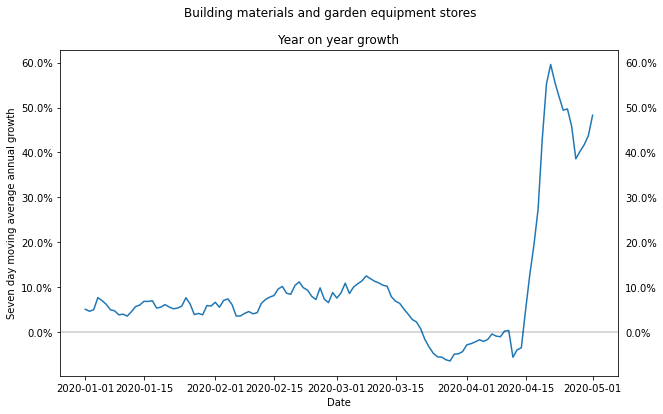

In [124]:
plot_publication(*extract_ytd_rolling_mean_comps(build_daily, 'net_amt'), 'Building materials and garden equipment stores', 'build_mat.png')

In [125]:
# Check for furniture stores, included or not?
build_raw = align_marts_with_feature_yoy_chg(marts, 'build_mat_garden_raw', build_daily, 'net_amt')

In [126]:
build_diff = diffs(build_raw, 'net_amt', 'build_mat_garden_raw', '2019-07')
build_diff

2019-07-31    0.011246
2019-08-31    0.009769
2019-09-30   -0.014251
2019-10-31    0.001345
2019-11-30    0.015029
2019-12-31   -0.015995
2020-01-31    0.052142
2020-02-29    0.034716
2020-03-31   -0.086619
2020-04-30         NaN
Freq: M, dtype: float64

In [150]:
build_diff.mean(), build_diff.median()

(0.0008200673446073904, 0.009769079685206572)

In [127]:
error(build_diff, 0.9)

0.05903748554071178

In [128]:
build_predict = predict_month(marts, 'build_mat_garden_raw', build_raw, 'net_amt', '2020-04-30')
build_predict

43441.690260816125

In [129]:
build_predict / marts['build_mat_garden_raw'].loc['2019-04-30'] - 1

0.2535113764085908

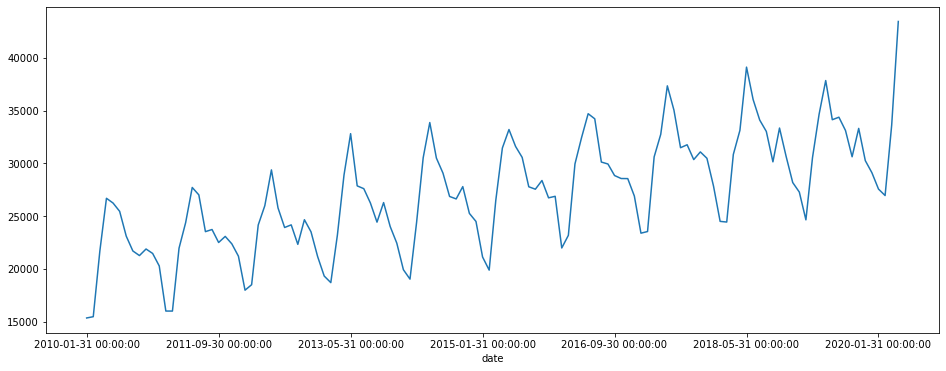

In [131]:
plot_prediction(marts, 'build_mat_garden_raw', build_raw, 'net_amt', '2020-04-30')

In [132]:
build_sa_factor = march_sa['Building mat. and garden equip. and supp. dealers']
build_sa = build_sa_factor * build_predict
build_sa / marts['build_mat_garden_raw'].loc['2019-03-31'] - 1

0.40652889635131095

# Weekly annual change

Prepare a sheet for export to Excel.

In [151]:
weekly_chart_start_date = '2020-02-23'
weekly_chart_end_date = '2020-05-03'

In [152]:
weekly_stats = []
for daily_stats in [daily_metrics, food_service_daily, food_bev_daily, gen_merch_daily, nonstore_daily, build_daily]:
    weekly_stats.append(weekly_annual_change(daily_stats, 'net_amt', weekly_chart_start_date, weekly_chart_end_date))

In [153]:
weekly = pd.DataFrame(weekly_stats).T

weekly.columns = [
    'Retail and food service', 
    'Food service', 
    'Food and beverage stores', 
    'General merchandise stores',
    'Nonstore retailers',
    'Building materials and garden equipment stores']

weekly

,Retail and food service,Food service,Food and beverage stores,General merchandise stores,Nonstore retailers,Building materials and garden equipment stores
txn_date,,,,,,
2020-02-23,0.030519,0.041960,-0.001573,0.020414,0.123320,0.090358
2020-03-01,-0.004693,0.018124,0.005968,0.050378,0.129175,0.070049
2020-03-08,0.071718,0.037946,0.097512,0.114048,0.217023,0.120492
2020-03-15,0.042416,-0.109049,0.415368,0.221569,0.234043,0.060032
2020-03-22,-0.084832,-0.474645,0.417861,0.011520,0.211497,-0.024434
2020-03-29,-0.254445,-0.544521,0.049616,-0.174461,0.227403,-0.048155
2020-04-05,-0.178426,-0.507754,0.148715,-0.065651,0.400900,-0.032112
2020-04-12,-0.207198,-0.485735,0.138543,-0.064986,0.447004,-0.041871
2020-04-19,0.002291,-0.353591,0.150966,0.233706,1.100152,0.489773


In [154]:
weekly.to_csv('weekly.csv')

# Seasonal adjustments

In [84]:
sa

,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
Sector,,,,,,,,,,,,,,,,,
"Retail Sales and Food Services, total",1.132,0.905,0.878,1.010,0.989,1.057,0.996,1.017,1.039,0.950,1.000,1.020,1.129,0.910,0.909,1.000,0.994
"Retail Sales, total",1.145,0.903,0.873,1.002,0.987,1.057,0.992,1.017,1.038,0.947,0.999,1.027,1.148,0.907,0.904,0.993,0.991
Motor vehicle and parts dealers,0.995,0.883,0.891,1.073,1.010,1.090,1.016,1.058,1.090,0.957,0.991,0.948,0.991,0.886,0.924,1.057,1.019
Automobile and other motor vehicle dealers,1.000,0.877,0.892,1.077,1.010,1.093,1.016,1.059,1.093,0.956,0.983,0.947,0.995,0.880,0.925,1.059,1.019
"Automotive parts, acc., and tire stores",0.909,0.933,0.892,1.034,1.021,1.059,1.010,1.054,1.063,0.976,1.065,0.973,0.925,0.931,0.915,1.041,1.025
Furniture and home furnishings stores,1.137,0.907,0.874,1.007,0.946,1.022,0.970,1.009,1.048,0.988,1.008,1.092,1.135,0.913,0.904,0.997,0.953
Electronics and appliance stores,1.461,0.940,0.867,0.949,0.861,0.935,0.928,0.943,0.993,0.937,0.939,1.242,1.457,0.948,0.894,0.945,0.859
Building mat. and garden equip. and supp. dealers,0.889,0.827,0.786,0.963,1.115,1.228,1.098,1.093,1.030,0.968,1.053,0.947,0.905,0.827,0.806,0.989,1.120
Building mat. and supplies dealers,0.890,0.838,0.791,0.948,1.074,1.195,1.088,1.109,1.047,0.985,1.062,0.964,0.903,0.835,0.806,0.977,1.083
